# 21기 KNN 정규세션 과제

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings(action='ignore')

## 0. 데이터 불러오기

In [2]:
df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


## 1. Preprocssing / EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


### 결측치

In [4]:
df.isnull().sum()

User_ID                          0
Product_ID                       0
Gender                           0
Age                              0
Occupation                       0
City_Category                    0
Stay_In_Current_City_Years       0
Marital_Status                   0
Product_Category_1               0
Product_Category_2            1533
Product_Category_3            3454
Purchase                         0
dtype: int64

➡️ 전체 데이터 개수 대비 **`Product_Category_3`** 결측치가 많아서 **컬럼 제거**

In [5]:
# 컬럼 제거 
df.drop('Product_Category_3', axis = 1, inplace = True)

✅ **`Product_Category_2`** 결측치 

- **`Product_Category_1`** 과 **`Product_ID`** 중 상관관계가 높은 컬럼을 기준으로 **`Product_Category_2`** 의 결측치를 처리한다
- 이때, **`Product_ID`** 의 일렬번호 앞부분 일부만을 사용하여 그룹화한 뒤, 상관계수를 구한다
- 3개의 컬럼 모두 범주형 변수이므로, 크래머 V 계수를 사용하여 비교한다.

✅ Cramer's V 
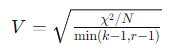

- 두 범주형 변수 사이의 관계 파악
- 비교 대상 범주 대상이 3개 이상인 경우

In [6]:
def cramers_v(df, col1, col2) :
    cross_tab = pd.crosstab(df[col1], df[col2])
    
    # 카이제곱 검정 수행
    chi2, p, dof, expected = chi2_contingency(cross_tab)

    # 크래머의 V 계산
    n = cross_tab.sum().sum()  # 총 관측치 수
    min_dim = min(cross_tab.shape) - 1  # k (행) 와 r (열) 중 작은 값에서 1을 뺀 값
    cramers_v = np.sqrt(chi2 / (n * min_dim))
    
    return cramers_v

In [7]:
# Product_ID 일렬번호 앞부분 생성
df['Serial_Number'] = df['Product_ID'].str[:4]
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase,Serial_Number
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,2010,P000
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,4483,P003
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,7696,P000
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,16429,P001
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,5780,P001


In [8]:
# Serial_Number, Product_Category_2 관계
cramers_v(df, 'Serial_Number', 'Product_Category_2')

0.17157116507337614

In [9]:
# Product_Category_1, Product_Category_2 관계
cramers_v(df, 'Product_Category_1', 'Product_Category_2')

0.40260250264303693

➡️ 크래머 계수를 비교했을 때, **`Product_Category_1`** 와의 값이 더 크기 때문에 이를 기준으로 결측치를 채운다. 단, 아래 결과와 같이 최빈값이 none인 경우가 나타난다. 최빈값을 구할 수 없는 데이터는 제거한다. 

In [10]:
# Product_Category_1 별 Product_Category_2의 최빈값 출력
cat1_mode = df.groupby('Product_Category_1')['Product_Category_2'].agg(pd.Series.mode)
cat1_mode

Product_Category_1
1      2.0
2      4.0
3      4.0
4      5.0
5      8.0
6      8.0
7     17.0
8     14.0
9       []
10    15.0
11    16.0
12    14.0
13    16.0
14    16.0
15    16.0
16      []
17      []
18      []
19      []
20      []
Name: Product_Category_2, dtype: object

In [11]:
# 최빈값 대체
for category, mode in cat1_mode.iteritems():
    if mode.size == 0 :
        continue
    else :
        df.loc[(df['Product_Category_1'] == category) & (df['Product_Category_2'].isnull()), 'Product_Category_2'] = mode

In [12]:
# 나머지 결측행 제거
df = df.dropna()

### EDA

<AxesSubplot:xlabel='Marital_Status', ylabel='Purchase'>

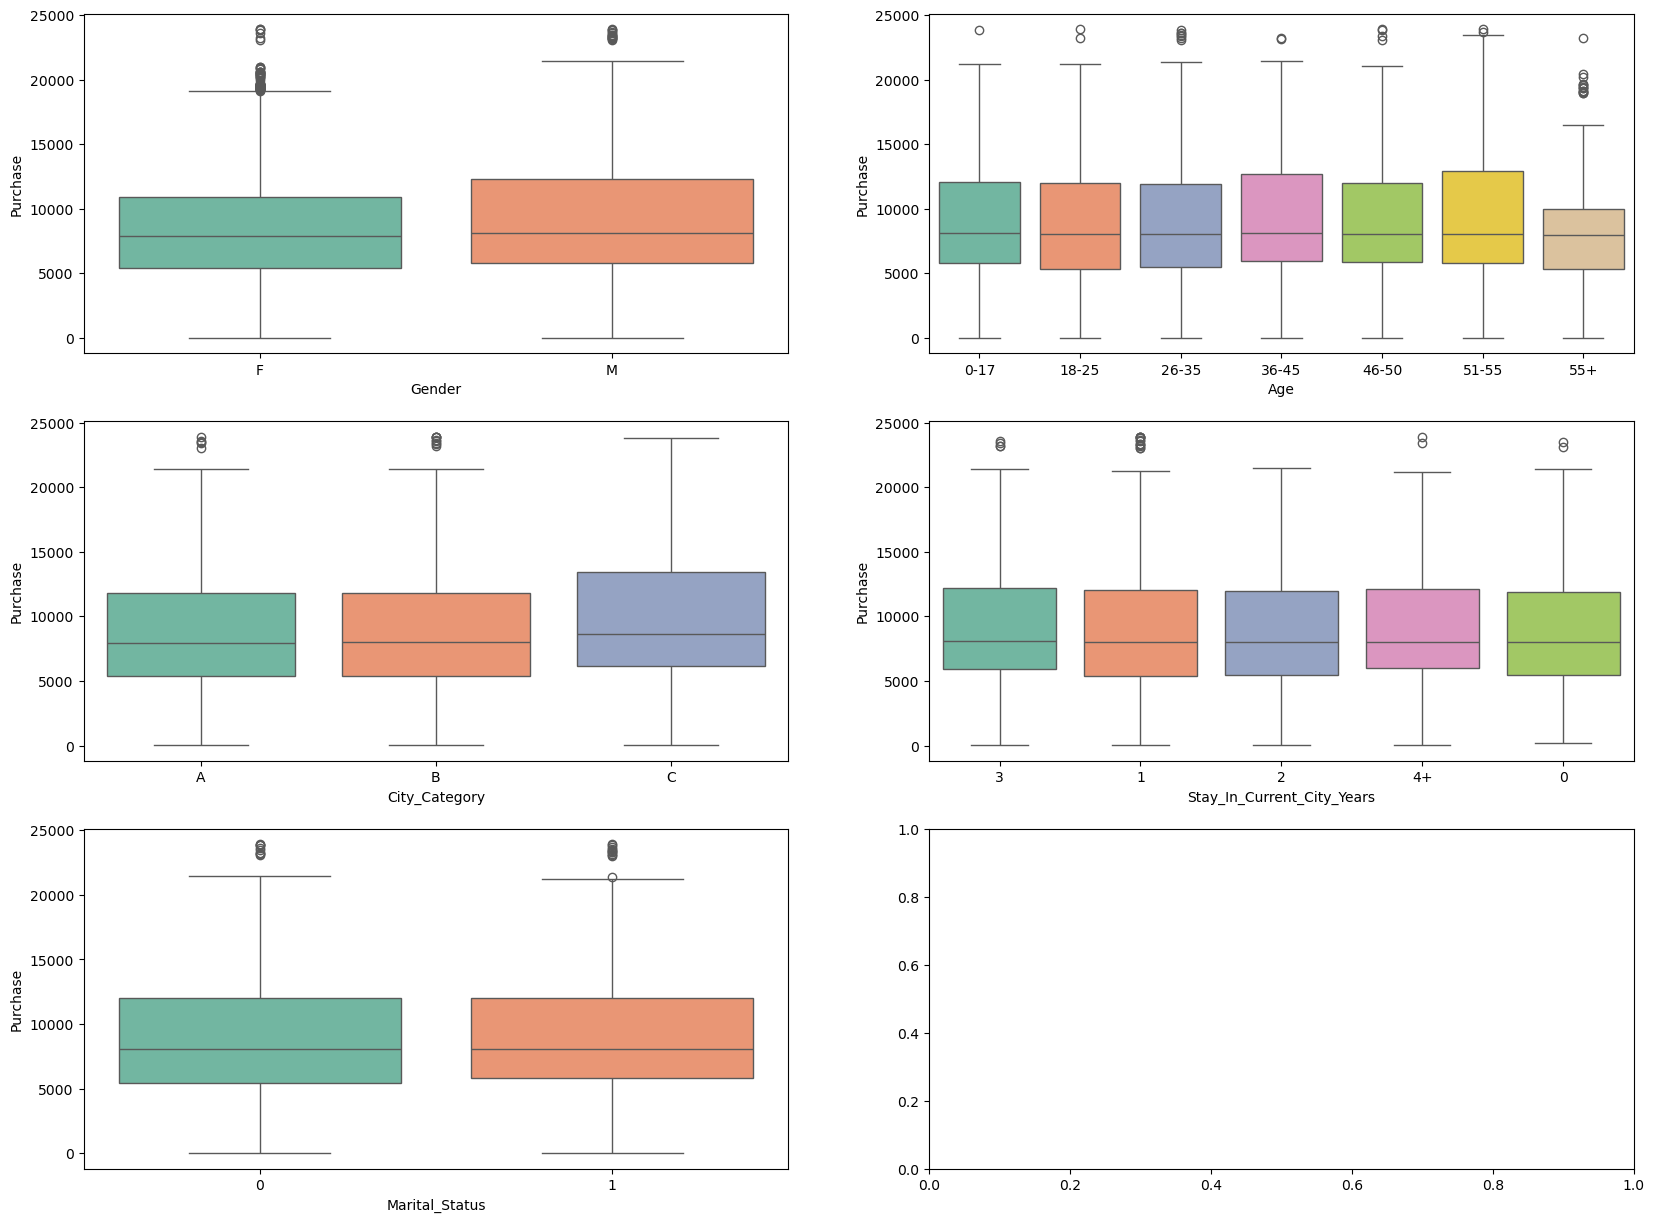

In [7]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))

sns.boxplot(x='Gender', y='Purchase', data=df, palette='Set2', ax=ax[0, 0])

sns.boxplot(x='Age', y='Purchase', data=df, palette='Set2',  ax=ax[0, 1])

sns.boxplot(x='City_Category', y='Purchase', data=df, palette='Set2',  ax=ax[1, 0])

sns.boxplot(x='Stay_In_Current_City_Years', y='Purchase', data=df, palette='Set2',  ax=ax[1, 1])

sns.boxplot(x='Marital_Status', y='Purchase', data=df, palette='Set2',  ax=ax[2, 0])

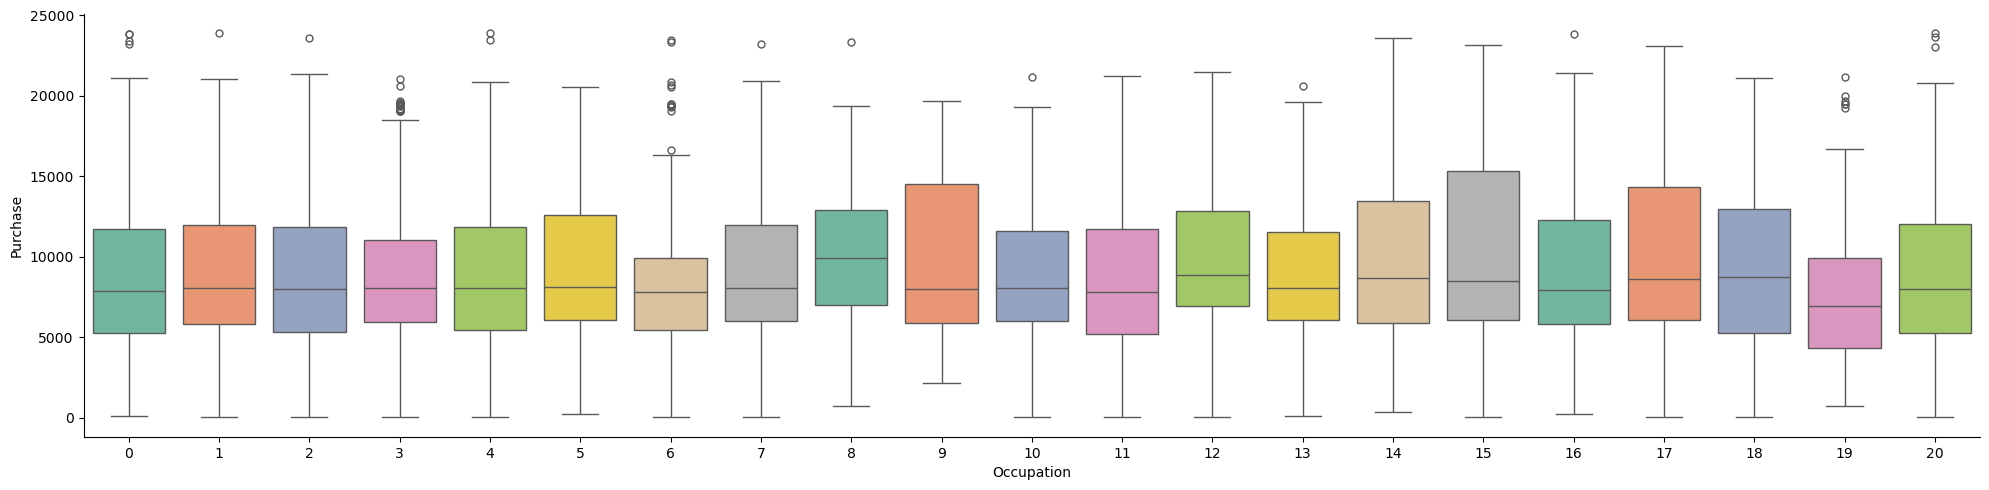

In [8]:
sns.catplot(x='Occupation', y='Purchase', data=df, kind = 'box', palette='Set2', aspect = 4)
plt.show()

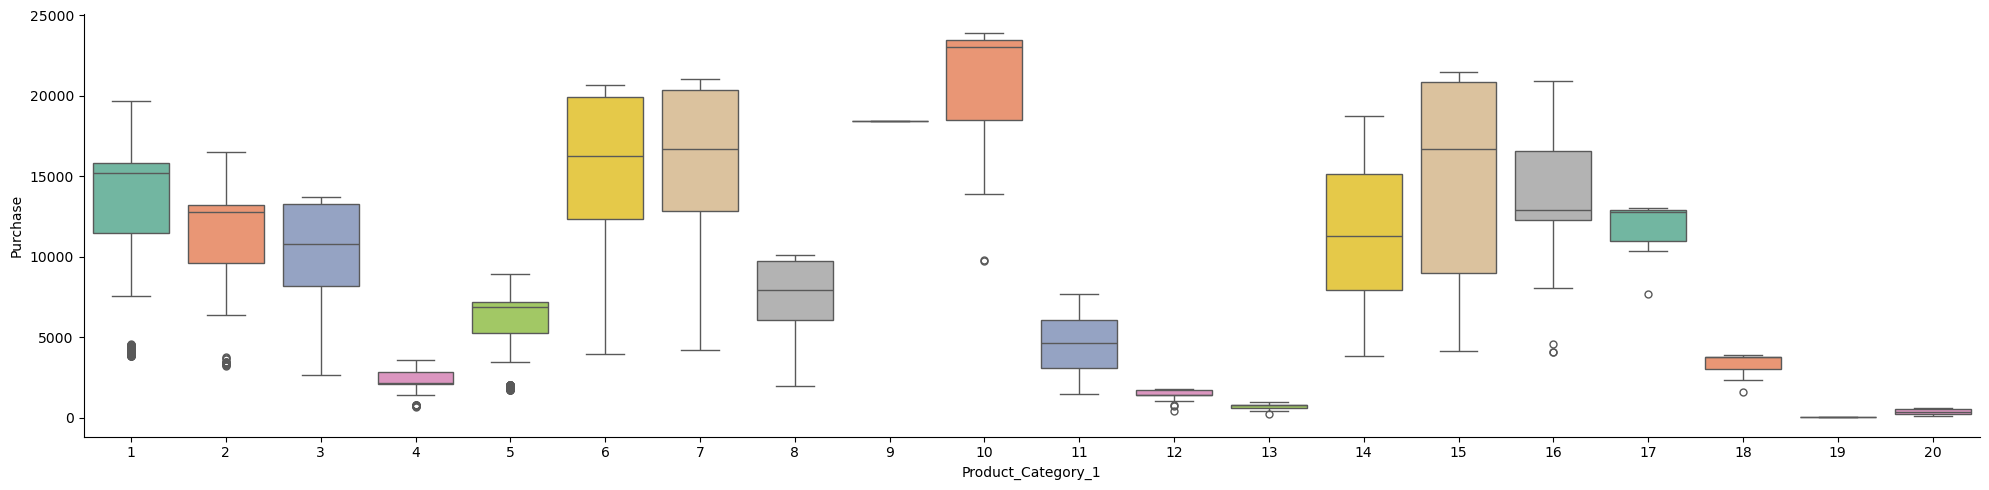

In [9]:
sns.catplot(x='Product_Category_1', y='Purchase', data=df, kind = 'box', palette='Set2', aspect = 4)
plt.show()

### 컬럼 제거

In [13]:
df.drop(['User_ID', 'Product_ID','Serial_Number'], axis =1, inplace = True)

### 중복 확인

In [19]:
df[df.duplicated()]

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Purchase
343,F,18-25,4,C,4+,0,5,8.0,5259


In [20]:
df = df.drop_duplicates(keep='first')

### 원핫인코딩

In [23]:
categorical_cols = ['Gender', "Age", "Occupation", 'Marital_Status','City_Category', 
                    'Stay_In_Current_City_Years', 'Product_Category_1', 
                    'Product_Category_2']
dummy_df = pd.get_dummies(df, columns=categorical_cols)
dummy_df.columns

Index(['Purchase', 'Gender_F', 'Gender_M', 'Age_0-17', 'Age_18-25',
       'Age_26-35', 'Age_36-45', 'Age_46-50', 'Age_51-55', 'Age_55+',
       'Occupation_0', 'Occupation_1', 'Occupation_2', 'Occupation_3',
       'Occupation_4', 'Occupation_5', 'Occupation_6', 'Occupation_7',
       'Occupation_8', 'Occupation_9', 'Occupation_10', 'Occupation_11',
       'Occupation_12', 'Occupation_13', 'Occupation_14', 'Occupation_15',
       'Occupation_16', 'Occupation_17', 'Occupation_18', 'Occupation_19',
       'Occupation_20', 'Marital_Status_0', 'Marital_Status_1',
       'City_Category_A', 'City_Category_B', 'City_Category_C',
       'Stay_In_Current_City_Years_0', 'Stay_In_Current_City_Years_1',
       'Stay_In_Current_City_Years_2', 'Stay_In_Current_City_Years_3',
       'Stay_In_Current_City_Years_4+', 'Product_Category_1_1',
       'Product_Category_1_2', 'Product_Category_1_3', 'Product_Category_1_4',
       'Product_Category_1_5', 'Product_Category_1_6', 'Product_Category_1_7',
     

## 2. KNN 구현 & 파라미터 튜닝

In [46]:
# train, test set 분리
X = dummy_df.drop(['Purchase'], axis=1)
y = dummy_df['Purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 42)

In [47]:
# 표준화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [48]:
# KNN 
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [49]:
y_pred = knn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

15842908.68747162


### 하이퍼파라미터 튜닝

In [62]:
grid_params = {
    'n_neighbors' : [3,5,7,9,11,13,15,19],
    'weights' : ["uniform", "distance"],
    'metric' : ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(knn, grid_params, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

print("Best Parameters : ", grid_search.best_params_)
print("Best Score : ", -grid_search.best_score_)

Best Parameters :  {'metric': 'euclidean', 'n_neighbors': 19, 'weights': 'uniform'}
Best Score :  14461133.583656695


## 3. Evaluation

In [63]:
y_pred = grid_search.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE : {:.2f}".format(mse))

MSE : 14768825.86
